<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="National Weather Service">
</a>

# GOES-16: Geostationary Lightning Mapper
__Brian Blaylock__ | _blaylock@gmail.com_ | [_website_](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)   |  
__May 29, 2018__  


This Python notebook shows how to plot data from the GOES-16 Geostationary Lightning Mapper (GLM) on a `Basemap`. 

Other Notebooks: |[True Color](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_data.ipynb)|[Fire Temperature](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_FireTemperature.ipynb)|

##### Download GOES-16 GLM Data
For this demo, you will first need a GOES-16 GLM data file. You can get GOES-16 GLM files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?product=GLM-L2-LCFA) to easily download files from the Amazon archive.


##### About the GLM<sup>1</sup>

The Geostationary Lightning Mapper measures total lightning in a column (cloud-to-cloud and cloud-to-ground) and uses a near-infrared optical channel (0.77 um) to detect flashes.

- Resolution: approxamatly 10 km
- Data output: every 20 seconds
- Field of View (lat): 66.5 North and -66.5 South
- Field of View (lon): -141.5 West and -8.43 East

Note: GOES-East GLM does not cover the Northwest (i.e. Washington, Oregon, Northern California)<sup>2</sup>

##### Data types<sup>3</sup>
1. Event
2. Group
3. Flash
    
As far as I can tell, you will most likely use the flash dataset, which clusters nearby detections.

---- 

<sup>1</sup> https://www.goes-r.gov/spacesegment/glm.html  
<sup>2</sup> https://www.goes-r.gov/products/ATBDs/baseline/Lightning_v2.0_no_color.pdf (page 10)  
<sup>3</sup> https://www.goes-r.gov/products/ATBDs/baseline/Lightning_v2.0_no_color.pdf (page 13-14)


----------

### First, import some libraries we will use

In [25]:
%matplotlib inline

from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### Open and Read the GOES-16 NetCDF File

In [2]:
# I previously downloaded this file from AWS
GLM_file = './OR_GLM-L2-LCFA_G16_s20181482132400_e20181482133000_c20181482133024.nc'
GLM = Dataset(GLM_file, 'r')

### Image's Date/Time Information

In [3]:
# Date will be the end scan date. Durration of detection window is previous 20 seconds
DATE = datetime.strptime(GLM.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
print DATE

2018-05-28 21:31:40


### Lightning Data

In [4]:
print GLM.title
print GLM.summary

GLM L2 Lightning Detections: Events, Groups, and Flashes
The Lightning Detections: Events, Groups, and Flashes product consists of a hierarchy of earth-located lightning radiant energy measures including events, groups, and flashes. Lightning events are detected by the instrument. Lightning groups are a collection of one or more lightning events that satisfy temporal and spatial coincidence thresholds. Similarly, lightning flashes are a collection of one or more lightning groups that satisfy temporal and spatial coincidence thresholds. The product includes the relationship among lightning events, groups, and flashes, and the area coverage of lightning groups and flashes. The product also includes processing and data quality metadata, and satellite state and location information.


In [5]:
GLM.variables['flash_energy']

<type 'netCDF4._netCDF4.Variable'>
int16 flash_energy(number_of_flashes)
    _FillValue: -1
    long_name: GLM L2+ Lightning Detection: flash radiant energy
    standard_name: lightning_radiant_energy
    _Unsigned: true
    valid_range: [ 0 -6]
    scale_factor: 1.52597e-15
    add_offset: 0.0
    units: J
    coordinates: group_parent_flash_id flash_id lightning_wavelength flash_time_threshold flash_time_offset_of_first_event flash_time_offset_of_last_event flash_lat flash_lon
    grid_mapping: goes_lat_lon_projection
    cell_measures: area: flash_area
    cell_methods: lightning_wavelength: sum flash_time_offset_of_first_event: flash_time_offset_of_last_event: sum area: mean (centroid location of constituent events defined by variables group_parent_flash_id and event_parent_group_id weighted by their radiant energies) where cloud
    ancillary_variables: flash_quality_flag
unlimited dimensions: number_of_flashes
current shape = (409,)
filling on

 ### Plot on a Basemap: Lambert Conformal Projection
 I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.
 
 Remember, GOES-East GLM does not see the Northwest

In [6]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

##### Flash Location

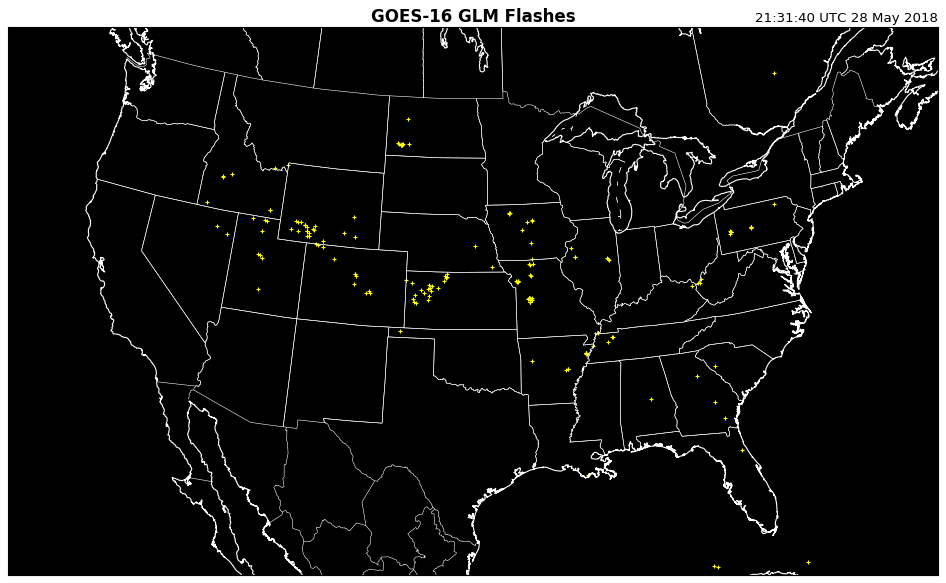

In [7]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[15, 10])

# Marker for each flash
mH.scatter(GLM.variables['flash_lon'][:], GLM.variables['flash_lat'][:],
           marker='+',
           color='yellow',
           latlon=True)

mH.drawmapboundary(fill_color='k')
mH.drawcoastlines(color='w')
mH.drawcountries(color='w')
mH.drawstates(color='w')

plt.title('GOES-16 GLM Flashes', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M:%S UTC %d %B %Y'), loc='right')

##### Flash Energy

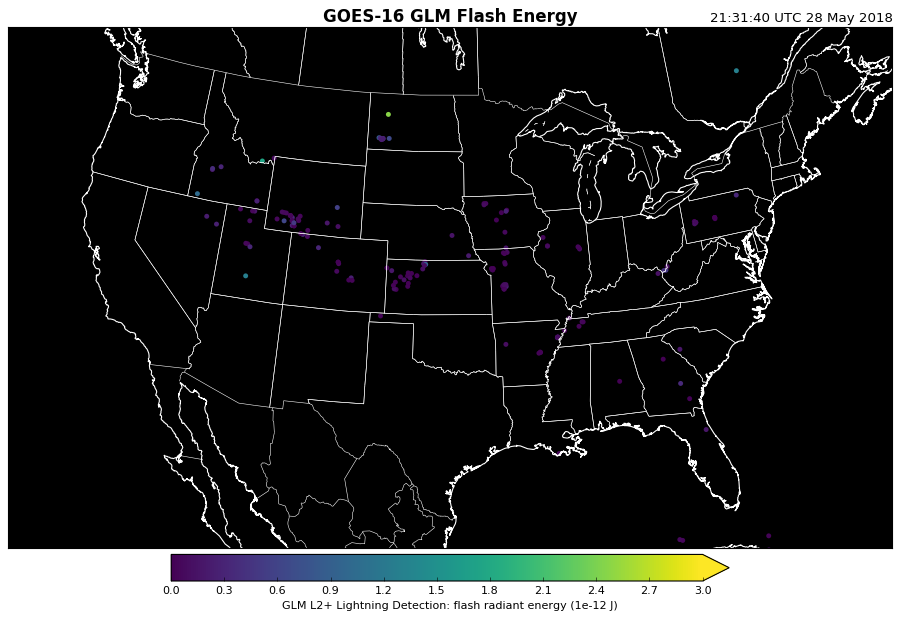

In [8]:
plt.figure(figsize=[15, 10])

scale = 1e-12

# Energy in the flash
mH.scatter(GLM.variables['flash_lon'][:], GLM.variables['flash_lat'][:],
           c=GLM.variables['flash_energy'][:]/scale,
           edgecolor='none',
           vmax=3, vmin=0,
           cmap='viridis',
           latlon=True)

cb = plt.colorbar(orientation='horizontal', shrink=.6, pad=.01, extend='max')
cb.set_label('%s (%s %s)' % (GLM.variables['flash_energy'].long_name, scale, GLM.variables['flash_energy'].units))


mH.drawmapboundary(fill_color='k')
mH.drawcoastlines(color='w')
mH.drawcountries(color='w')
mH.drawstates(color='w')

plt.title('GOES-16 GLM Flash Energy', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M:%S UTC %d %B %Y'), loc='right')

---
I have no idea what is up with the `event` and `group` latitude and longitude values. The values are not valid latitude and longitdues. If anyone out there figures this out, email me at brian.blaylock@utah.edu

# Overlay GLM with ABI
ABI is the Advanced Baseline Imager that can be used to make [True Color](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_data.ipynb) and [Fire Temperature](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_GOES16/mapping_GOES16_FireTemperature.ipynb) images. The main difference between GLM and ABI data is that GLM writes output files every 20 seconds and ABI scans of the CONUS occure every 5 minutes. Thus, to overlay the lightning data on top of, say, a True Color image, we need to accumulate all the lightning data for the 5 minute period. This equates to opening 15 different GLM files per ABI image.

The below two functions accomplish this data matching:

In [21]:
def get_GLM_files_for_ABI(FILE):
    """
    Get all the GLM 'flashes' data file names that occurred within the 5-minute
    scan window for an ABI scan.

    Input:
        FILE - the path and file name of an ABI scan
    """
    # GOES16 ABI and GLM data is stored locally on horel-group7.
    # You can also get ABI and GLM data on Amazon AWS, OCC, and Pando.
    HG7 = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16'

    # Get info from the file name
    FILE_SPLIT = FILE.split('_')
    product = '-'.join(FILE_SPLIT[1].split('-')[:-1]) # remove the scan mode
    sDATE = datetime.strptime(FILE_SPLIT[3], 's%Y%j%H%M%S%f')
    eDATE = sDATE + timedelta(minutes=5)

    # Build path of file on horel-group7
    ABI = '%s/%s/%s/%s' % (HG7, product, sDATE.strftime('%Y%m%d'), FILE)

    # Need to pay attention to weather or not the sDATE.hour and eDATE.hour 
    # are equal. If they are not, then we need to grab GLM data from two 
    # dirtories because the ABI scan spans two different hours.

    if sDATE.hour == eDATE.hour:
        GLM_DIR = '%s/GLM-L2-LCFA/%s/%02d' % (HG7, sDATE.strftime('%Y%m%d'), sDATE.hour)
        GLM = os.listdir(GLM_DIR)
        GLM = ['%s/%s' % (GLM_DIR, i) for i in GLM]
    else:
        GLM_DIR1 = '%s/GLM-L2-LCFA/%s/%02d' % (HG7, sDATE.strftime('%Y%m%d'), sDATE.hour)
        GLM1 = os.listdir(GLM_DIR1)
        GLM1 = ['%s/%s' % (GLM_DIR1, i) for i in GLM1]

        GLM_DIR2 = '%s/GLM-L2-LCFA/%s/%02d' % (HG7, eDATE.strftime('%Y%m%d'), eDATE.hour)
        GLM2 = os.listdir(GLM_DIR2)
        GLM2 = ['%s/%s' % (GLM_DIR2, i) for i in GLM2]
        
        GLM = GLM1 + GLM2

    GLM_FILES = filter(lambda x: datetime.strptime(x.split('_')[4], 'e%Y%j%H%M%S%f') < eDATE
                            and  datetime.strptime(x.split('_')[4], 'e%Y%j%H%M%S%f') >= sDATE, GLM)

    return_this = {'Files': GLM_FILES,
                   'Range': [sDATE, eDATE]                  
                  }
    
    return return_this

In [22]:
def accumulate_GLM_flashes_for_ABI(FILE, data_type='flash'):
    """
    Accumulate all the GLM 'flash' data that occurred within the 5-minute
    scan window for an ABI file and return the latitude, longitude, and energy
    of all the flashes.

    Input:
        FILE      - The file name of an ABI scan
        data_type - Data to retrieve. Default is 'flash' data. Other options 
                    are 'event' and 'group' which have messed up latitude and
                    longitude, so don't use them unless you figure them out.
    
    Output:
        A dictionary containing the latitudes, longitudes, and energy of each
        flash (or event or group). The num_per_20_seconds is a list of length
        of observations per file. If you need to, you can separate the data
        values by the data's 20-second intervals rather than the 5-minute lump.
    """
    # Get a list of GLM file names for the ABI file of interest
    GLM = get_GLM_files_for_ABI(FILE)

    # Initialize arrays for latitude, longitude, and flash energy
    lats = np.array([])
    lons = np.array([])
    energy = np.array([])
    num_per_20_seconds = np.array([])

    # Read the data
    for i, FILE in enumerate(GLM['Files']):
        G = Dataset(FILE, 'r')
        lats = np.append(lats, G.variables[data_type+'_lat'][:])
        lons = np.append(lons, G.variables[data_type+'_lon'][:])
        energy = np.append(energy, G.variables[data_type+'_energy'][:])
        num_per_20_seconds = np.append(num_per_20_seconds, len(G.variables[data_type+'_lat'][:]))
        G.close()

    return {'latitude': lats,
            'longitude': lons,
            'energy': energy,
            'number of values each 20 seconds': num_per_20_seconds,
            'DATETIME': GLM['Range']}

In [23]:
ABI = 'OR_ABI-L2-MCMIPC-M3_G16_s20181282357201_e20181282359574_c20181290000075.nc'

In [26]:
## Get Cooresponding GLM files
GLM = accumulate_GLM_flashes_for_ABI(ABI)

In [50]:
import h5py
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_GOES16.get_GOES16 import get_GOES16_truecolor

In [51]:
# Get GOES16 TrueColor data for the ABI scan
product = ABI.split('_')[1][:-3]
DATE = datetime.strptime(ABI.split('_')[3], 's%Y%j%H%M%f')

In [52]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/%s/%s/' % (product, DATE.strftime('%Y%m%d')) 
G = get_GOES16_truecolor(DIR+ABI)

h = h5py.File('/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/goes16_conus_latlon_east.h5', 'r')
lons = h['longitude'][:]
lats = h['latitude'][:]

Fetching: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180508/OR_ABI-L2-MCMIPC-M3_G16_s20181282357201_e20181282359574_c20181290000075.nc

   Gamma correction: 0.4
   Contrast correction: 150



Datetime Range: [datetime.datetime(2018, 5, 8, 23, 57, 20, 100000), datetime.datetime(2018, 5, 9, 0, 2, 20, 100000)]


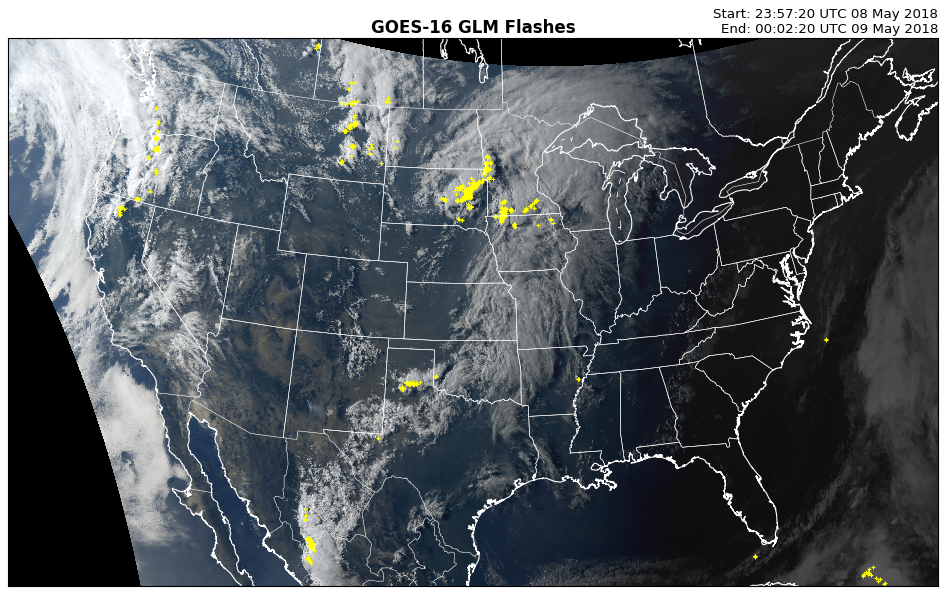

In [54]:
## Plot each GLM file on the map
plt.figure(figsize=[15, 10])

print 'Datetime Range:', GLM['DATETIME']

newmap = mH.pcolormesh(lons, lats, G['TrueColor'][:,:,1],
                       color=G['rgb_tuple'],
                       linewidth=0, latlon=True)
newmap.set_array(None) # must have this line if using pcolormesh and linewidth=0

mH.scatter(GLM['longitude'], GLM['latitude'],
            marker='+',
            color='yellow',
            latlon=True)

mH.drawmapboundary(fill_color='k')
mH.drawcoastlines(color='w')
mH.drawcountries(color='w')
mH.drawstates(color='w')

plt.title('GOES-16 GLM Flashes', fontweight='semibold', fontsize=15)
plt.title('Start: %s\nEnd: %s' % (GLM['DATETIME'][0].strftime('%H:%M:%S UTC %d %B %Y'), GLM['DATETIME'][1].strftime('%H:%M:%S UTC %d %B %Y')), loc='right')    